# Loading data

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

In [2]:
data = tfds.load(name='lfw', as_supervised=True)
pure_data = data['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete4ZKBQY/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
def create_faces_dics(data):
  faces_dict = {}
  for label, image in tqdm(data):
    label = label.numpy().decode('utf-8')

    if label not in faces_dict.keys():
      faces_dict[label] = []

    faces_dict[label].append(image)

  return faces_dict    

In [4]:
faces_dict = create_faces_dics(pure_data)

  0%|          | 0/13233 [00:00<?, ?it/s]

In [5]:
print(f'#persons: {len(faces_dict.keys())}')

counter = 0
for key, value in faces_dict.items():
  counter += len(value)

print(f'#images: {counter}')

#persons: 5749
#images: 13233


In [6]:
def generate_all_possitive_labels(faces_dics, name):
  images = faces_dics[name]
  total_length = len(images)

  first_face_list = []
  second_face_list = []

  for i in range(total_length):
    for j in range(i+1, total_length):
      first_face_list.append(images[i])
      second_face_list.append(images[j])

  return first_face_list, second_face_list

In [7]:
def generate_all_negative_labels(faces_dics, first_key, second_key):
  first_face_list = []
  second_face_list = []

  for first_face in faces_dics[first_key]:
    for second_face in faces_dics[second_key]:
      first_face_list.append(first_face)
      second_face_list.append(second_face)

  return first_face_list, second_face_list

In [8]:
def generate_all_pairs(face_dict, limit=-1):
  first_face_list = []
  second_face_list = []
  labels = []

  counter = 0

  faces = list(face_dict.keys())

  for first_face in tqdm(range(len(faces))):

    if counter == limit:
      print('Limit reached')
      break
    counter += 1

    first, second = generate_all_possitive_labels(face_dict, faces[first_face])

    first_face_list.extend(first)
    second_face_list.extend(second)
    labels.extend([0 for _ in range(len(first))])

    for second_face in range(first_face + 1, len(faces)):

        first, second = generate_all_negative_labels(face_dict, faces[first_face], faces[second_face])

        first_face_list.extend(first)
        second_face_list.extend(second)
        labels.extend([0 for _ in range(len(first))])


  return first_face_list, second_face_list, labels

In [9]:
first_face_list, second_face_list, labels_list = generate_all_pairs(faces_dict)

  0%|          | 0/5749 [00:00<?, ?it/s]

In [10]:
def get_data_generator(first_face, second_face, labels):
  def data_generator():
    for first, second, label in zip(first_face, second_face, labels):
      yield {'first_face': first, 'second_face':second}, label

  return data_generator

In [11]:
dataset = tf.data.Dataset.from_generator(
    get_data_generator(first_face_list, second_face_list, labels_list),
    # output_signature=(
    #      tf.TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name='first_face'),
    #      tf.TensorSpec(shape=(250 , 250, 3), dtype=tf.float32, name='second_face'),
    #      tf.TensorSpec(shape=(1,), dtype=tf.int32, name='label'),
    # )
     output_types=({"first_face": tf.float32, "second_face": tf.float32}, tf.int64)
)

In [12]:
dataset = dataset.shuffle(1000)

In [13]:
train_count = 2 ** 15
test_count = 256

train_dataset = dataset.take(train_count).batch(32)
test_dataset = dataset.skip(train_count).take(test_count).batch(32)

In [14]:
# train_dataset.take(1)

# Creating model

In [15]:
from tensorflow.keras import backend as K

def euclidean_distance(vectors):
  first_embedding, second_embedding = vectors

  sum_squared = K.sum(K.square(first_embedding - second_embedding),
      axis=1,
      keepdims=True
  )

  return K.maximum(sum_squared, K.epsilon())

In [25]:
def contrastive_loss(margin=1):
  def loss_function(y, preds):
    y = tf.cast(y, preds.dtype)

    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin - preds, 0))

    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)

    return loss
  return loss_function

In [17]:
import tensorflow_hub as hub

model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(model_url,
                                   output_shape=[1280],
                                   input_shape=[],
                                   trainable=False)

In [18]:
base_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(250, 250, 3)),
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255),
  feature_extractor,
  tf.keras.layers.Dense(256),
])

In [19]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
Total params: 2,585,920
Trainable params: 327,936
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
first_face = tf.keras.Input(shape=(250, 250, 3), name='first_face')
second_face = tf.keras.Input(shape=(250, 250, 3), name='second_face')

first_embedding = base_model(first_face)
second_embedding = base_model(second_face)

output_layer = tf.keras.layers.Lambda(euclidean_distance)([first_embedding, second_embedding])

model = tf.keras.Model(
    inputs=[first_face, second_face],
    outputs=[output_layer]
)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_face (InputLayer)        [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 second_face (InputLayer)       [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256)          2585920     ['first_face[0][0]',             
                                                                  'second_face[0][0]']        

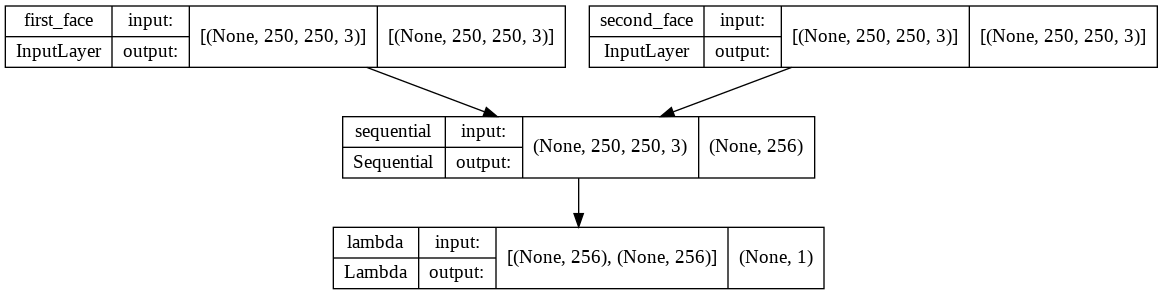

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
model.compile(
    loss=contrastive_loss(5),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    steps_per_epoch=128
)

Epoch 1/5
128/128 [==============================] - ETA: 0s - loss: 0.0000e+00